In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

fair_GRU_test = False

In [2]:
def load(f):
    F = open(f,"r")
    out = []
    label = []
    for l in F:
        temp = [int(t) for t in l.split(",")]
        out.append(temp[1:])
        label.append(temp[0])
        
    return np.array(out),np.array(label)

train_data,train_label = load("./mnist_train.csv")
test_data,test_label = load("./mnist_test.csv")

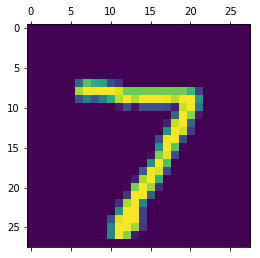

In [3]:
plt.matshow(np.reshape(test_data[0],[28,28]))
plt.show()

In [4]:
batch_size = 16
data_size = len(test_data[0])
data_edge = int(np.sqrt(data_size))
learning_rate = .001
n_epochs = 4000
n_labels = 10

nrnn_hidden_layer = 32

rec_state_size = 32

In [5]:
m = np.mean(train_data)
s = np.std(train_data)

normed_data = (train_data - m)/s

In [6]:
tf.reset_default_graph()

inputs = tf.placeholder(tf.float32,shape = (batch_size, data_size))
series = tf.transpose(tf.reshape(inputs,(-1,data_edge,data_edge)),[0,2,1])

labels = tf.placeholder(tf.float32,shape = (batch_size,10))

init_state = tf.zeros(shape = [rec_state_size])
init_gate_state = tf.zeros(shape = [rec_state_size])

This next cell is the powerhouse. The function I define takes a single time step batch of inputs, and the current state of the network, and returns an updated state using a single hidden layer of nonlinearity.

Note the `name` keyword and `reuse = tf.AUTO_REUSE`. The name identifies this layer unambiguously, and `tf.AUTO_REUSE` tells tensorflow to reuse the weights if this layer already exists, and create them if it doesn't. That way, every time we call the function `get_next_state`, it applies the same parameters to the inputs, and the gradients are tied across all time steps.

Next I have constructed a loop which recursively feeds the RNN state and a single "time" slice to `get_next_state`, and records the results in a list `state_out`. Afterwards we concatenate (`tf.concat`) them all together along the 1-th axis, generating a time series of state variables. 

Lastly, we reshape the time-dependent state and pass them all through a single dense layer to translate them into logits in the label dimention (`probs`).

In [7]:
def get_next_state(INP,STATE):
    net = tf.layers.dense(tf.concat([INP,STATE],axis = -1),nrnn_hidden_layer,name = "rnn_l1",reuse = tf.AUTO_REUSE,activation = tf.nn.relu)
    net = tf.layers.dense(net,STATE.shape[-1],name = "rnn_l2",reuse = tf.AUTO_REUSE)

    if fair_GRU_test:
        net2 = tf.layers.dense(tf.concat([INP,STATE],axis = -1),STATE.shape[-1],name = "gate_l1",reuse = tf.AUTO_REUSE,activation = tf.nn.sigmoid)
        net = net2 + net
        
    return net

state_out = [tf.tile(tf.expand_dims(init_state,0),(batch_size,1))]

for k in range(data_edge):
        state_out.append(get_next_state(series[:,k],state_out[-1]))
        
state_out = tf.stack(state_out,axis = 1)
print(state_out.shape)

flattened_state = tf.reshape(state_out,[-1,rec_state_size])
flattened_probs = tf.layers.dense(flattened_state,n_labels)
probs = tf.reshape(flattened_probs,[state_out.shape[0],state_out.shape[1],n_labels])

print(probs.shape)

(16, 29, 32)
(16, 29, 10)


For this notebook we are also going to make a simple 'gated recurrent unit' and train it alongside the vanilla RNN. WE do this in an analagous way as follows:

In [8]:
def get_next_gru_state(INP,STATE,gate):
    net = tf.layers.dense(tf.concat([INP,STATE],axis = -1),nrnn_hidden_layer,name = "gru_rnn_l1",reuse = tf.AUTO_REUSE,activation = tf.nn.relu)
    gout = tf.layers.dense(tf.concat([INP,STATE],axis = -1),STATE.shape[-1],name = "gru_gate_l1",reuse = tf.AUTO_REUSE,activation = tf.nn.sigmoid)
    net = gate * STATE + (1 - gate) * tf.layers.dense(net,STATE.shape[-1],name = "gru_rnn_l2",reuse = tf.AUTO_REUSE)

    return net,gout

gru_state_out = [tf.tile(tf.expand_dims(init_state,0),(batch_size,1))]
gru_gate_out = [tf.tile(tf.expand_dims(init_gate_state,0),(batch_size,1))]

for k in range(data_edge):
        st,g = get_next_gru_state(series[:,k],gru_state_out[-1],gru_gate_out[-1])
        gru_state_out.append(st)
        gru_gate_out.append(g)
        
gru_state_out = tf.stack(gru_state_out,axis = 1)
gru_gate_out = tf.stack(gru_gate_out,axis = 1)
print(gru_state_out.shape)

flattened_gru_state = tf.reshape(gru_state_out,[-1,rec_state_size])
flattened_gru_probs = tf.layers.dense(flattened_gru_state,n_labels)
gru_probs = tf.reshape(flattened_gru_probs,[state_out.shape[0],state_out.shape[1],n_labels])

print(probs.shape)

(16, 29, 32)
(16, 29, 10)


Here I constrtuct the loss function. I take the mean cross-entropy loss between prediction and label in the final `test_time` time steps. There is some shuffling of dimentions that happens here which could probably be skipped with a clever application of keyowrd arguments in various tensorflow functions. 

In [9]:
test_time = 20

time_label = tf.tile(tf.expand_dims(labels,1),[1,probs.shape[1],1])
flattened_label = tf.reshape(time_label[:,-test_time:],[-1,n_labels])

flattened_probs = tf.reshape(probs[:,-test_time:],[-1,n_labels])
test_probs = tf.nn.softmax(probs,axis = -1)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels = flattened_label,logits = flattened_probs))

flattened_gru_probs = tf.reshape(gru_probs[:,-test_time:],[-1,n_labels])
test_gru_probs = tf.nn.softmax(gru_probs,axis = -1)

loss1 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels = flattened_label,logits = flattened_probs)) 
loss2 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels = flattened_label,logits = flattened_gru_probs))

adam = tf.train.AdamOptimizer()
train = adam.minimize(loss1 + loss2)

In [10]:
def make_1hot(l):
    out = np.zeros(shape = (len(l),n_labels))
    for k in range(len(l)):
        out[k][l[k]] = 1
        
    return out

def MNIST_err(l,p):
    out = []
    for k in range(len(l)):
        if l[k][np.argmax(p[k])] == 1:
            out.append(1)
        else:
            out.append(0)
            
    return np.mean(out)

In [11]:
init = tf.global_variables_initializer()
config = tf.ConfigProto(device_count = {'GPU': 0})
sess = tf.Session(config=config)
sess.run(init)

In [12]:
results = []
print_freq = 100
test_freq = 100
normed_test = (test_data - m)/s
test_label_1h = make_1hot(test_label)

print("epoch\trnn\tgru\trnn*\tgru*")

for k in range(n_epochs):
    b_index = np.random.choice(range(len(test_data)),batch_size,replace = False)
    batch_data = normed_data[b_index]
    batch_labels = make_1hot(train_label[b_index])
    
    _,train_loss,gru_train_loss = sess.run([train,loss1,loss2],{inputs:batch_data,labels:batch_labels})

    if k%test_freq == 0:
        tres = []
        for j in range(len(normed_test)//16):
            tres.append(sess.run([loss1,loss2],{inputs:normed_test[j*16:(j+1)*16],labels:test_label_1h[j*16:(j+1)*16]}))
                        
        tres = np.mean(tres,axis = 1)
        results.append([k,train_loss,gru_train_loss,tres[0],tres[1]])
                        
    if k%print_freq == 0:
        print("{}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}".format(k,train_loss,gru_train_loss,tres[0],tres[1]))
        
        
results = np.array(results)

epoch	rnn	gru	rnn*	gru*
0	2.960	2.466	2.737	2.544
100	2.084	1.760	1.855	1.562
200	1.613	0.857	1.360	1.010
300	1.380	0.824	1.050	0.777
400	1.079	0.625	0.961	0.747
500	0.961	0.565	0.967	0.729
600	1.412	0.743	0.932	0.632
700	1.160	0.715	0.821	0.714
800	1.098	0.569	0.795	0.606
900	1.288	0.859	0.812	0.594
1000	0.769	0.740	0.743	0.539
1100	1.143	0.357	0.787	0.494
1200	1.024	0.650	0.861	0.545
1300	0.955	0.344	0.685	0.495
1400	0.995	0.514	0.677	0.467
1500	1.160	1.070	0.673	0.497
1600	0.498	0.251	0.568	0.494
1700	0.453	0.265	0.640	0.521
1800	0.849	0.365	0.592	0.576
1900	1.437	0.770	0.544	0.483
2000	0.639	0.284	0.571	0.496
2100	0.987	0.501	0.652	0.395
2200	0.667	0.320	0.623	0.449
2300	0.660	0.285	0.526	0.446
2400	0.294	0.137	0.493	0.413
2500	0.788	0.436	0.536	0.442
2600	0.590	0.246	0.572	0.362
2700	1.145	0.463	0.679	0.338
2800	0.963	0.594	0.564	0.482
2900	1.103	0.654	0.542	0.402
3000	0.808	0.296	0.510	0.514
3100	0.797	0.523	0.536	0.377
3200	1.471	0.586	0.499	0.382
3300	0.723	0.324	0.440	0.457
34

In [13]:
test,gru_test = sess.run([test_probs,test_gru_probs],{inputs:normed_test[:16],labels:test_label_1h[:16]})
sess.close()

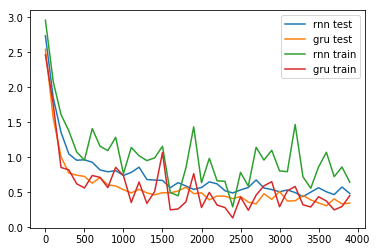

In [14]:
plt.plot(results[:,0],results[:,3],label = "rnn test")
plt.plot(results[:,0],results[:,4],label = "gru test")

plt.plot(results[:,0],results[:,1],label = "rnn train")
plt.plot(results[:,0],results[:,2],label = "gru train")
plt.legend()
plt.show()

Now it's always a clever idea to visualize the test performance to make sure your algorithm isn't just learning garbage! 

Here I will visualize the probabilities at each time step, against the image of the digit (aligned so that you can see what part of the image it was looking at at each time).

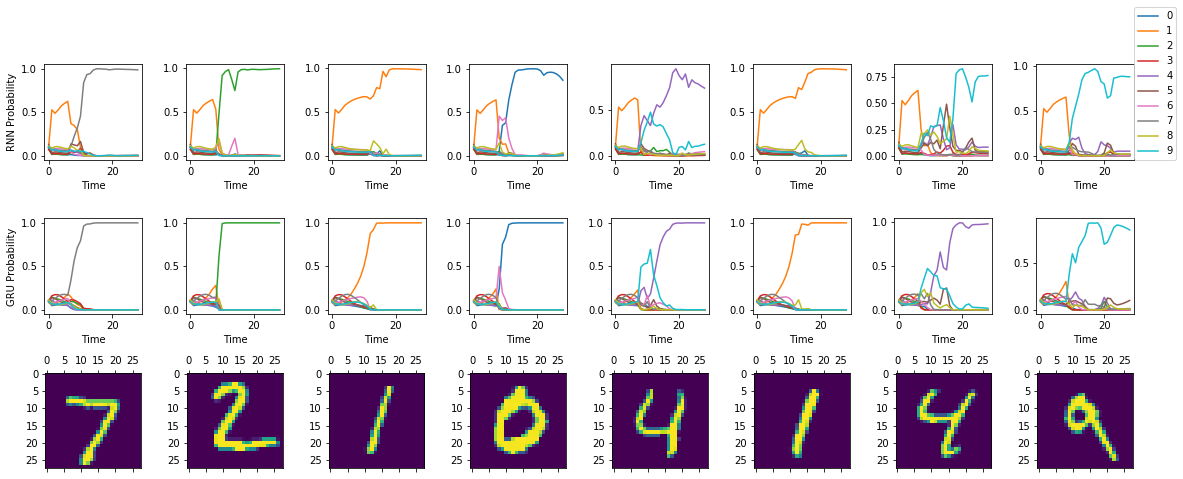

In [15]:
nfig = 8
fig,sub = plt.subplots(3,nfig,figsize = (nfig*2,6))

for ii in range(nfig):
    for kk in range(10):
        sub[0,ii].plot(test[ii,:,kk],label = kk)
        sub[0,ii].set_xlabel('Time')
            
        sub[1,ii].plot(gru_test[ii,:,kk],label = kk)
        sub[1,ii].set_xlabel('Time')

    sub[2,ii].matshow(np.reshape(test_data[ii],[data_edge,data_edge]))

sub[0,0].set_ylabel('RNN Probability')
sub[1,0].set_ylabel('GRU Probability')
sub[0,-1].legend(loc = [1,0])
plt.tight_layout()
plt.show()